## Machine learning classifiers for predicting no-show appointments

This is a notebook to test different classifiers on the dataset from Kaggle (noshowappointments). The goal is to predict whether a patient will show up for an appointment or not.
The notebook goal is to create the best classifier possible, and to compare the results of different classifiers. Also, explainable methods are employed to understand the results of the classifiers as the classifiers are used in a medical context. The classifiers developed are not explained by their structure.

The classifiers are tested on the dataset from Kaggle (noshowappointments). The dataset contains information about 110527 medical appointments in Brazil and is focused on the question of whether or not patients show up for their appointment. A number of characteristics about the patient are included in each row. The dataset is available at https://www.kaggle.com/joniarroba/noshowappointments.

The dataset has been cleaned and preprocessed in the notebook "eda-prep.ipynb". The cleaned dataset is saved in the file "cleaned_data.csv".

***

### Import libraries

In [1]:
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV

from xgboost import XGBClassifier, plot_importance
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score

from sklearn.inspection import PartialDependenceDisplay, partial_dependence

from imblearn.under_sampling import InstanceHardnessThreshold

from interpret.blackbox import LimeTabular
from interpret import show

import wandb

In [ ]:
!git clone https://github.com/SauceCat/PDPbox.git
%cd PDPbox
!python setup.py install

In [2]:
import pdpbox
from pdpbox import pdp

### Prepare data (split, deal with imbalanced data)

In [3]:
df = pd.read_csv('data/cleaned_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110521 entries, 0 to 110520
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   Gender                110521 non-null  int64
 1   Scholarship           110521 non-null  int64
 2   Hypertension          110521 non-null  int64
 3   Diabetes              110521 non-null  int64
 4   Alcoholism            110521 non-null  int64
 5   Handicap              110521 non-null  int64
 6   SMS_received          110521 non-null  int64
 7   Show                  110521 non-null  int64
 8   ScheduledHour         110521 non-null  int64
 9   ScheduledMonth        110521 non-null  int64
 10  AppointmentMonth      110521 non-null  int64
 11  AwaitingTimeDays      110521 non-null  int64
 12  ScheduledDayOfWeek    110521 non-null  int64
 13  AppointmentDayOfWeek  110521 non-null  int64
 14  AgeGroupInt           110521 non-null  int64
 15  NeighbourhoodInt      110521 non-n

In [4]:
X = df.drop(['Show'], axis=1)
y = df['Show']

In [5]:
print('Original dataset shape %s' % Counter(y))

Original dataset shape Counter({1: 88207, 0: 22314})


In [6]:
iht = InstanceHardnessThreshold(random_state=42)
X_res, y_res = iht.fit_resample(X, y)

In [7]:
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({1: 24367, 0: 22314})


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

In [9]:
print('X_train size: ', X_train.shape)
print('X_test size: ', X_test.shape)
print('y_train size: ', y_train.shape)
print('y_test size: ', y_test.shape)

X_train size:  (32676, 15)
X_test size:  (14005, 15)
y_train size:  (32676,)
y_test size:  (14005,)


In [10]:
print('y_train value counts: ', y_train.value_counts())
print('y_test value counts: ', y_test.value_counts())

y_train value counts:  1    17119
0    15557
Name: Show, dtype: int64
y_test value counts:  1    7248
0    6757
Name: Show, dtype: int64


### W&B for logging

In [11]:
WANDB_PROJECT_NAME = "mappshow-hp-optimize"

### XGBoost

In [12]:
xgboost_cls = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=8,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27
)

xgboost_cls.fit(X_train, y_train)

y_pred = xgboost_cls.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

print('Accuracy: %.2f%%' % (accuracy * 100.0))
print('F1 score: %.2f%%' % (f1 * 100.0))

Accuracy: 95.32%
F1 score: 95.31%


#### Feature importance

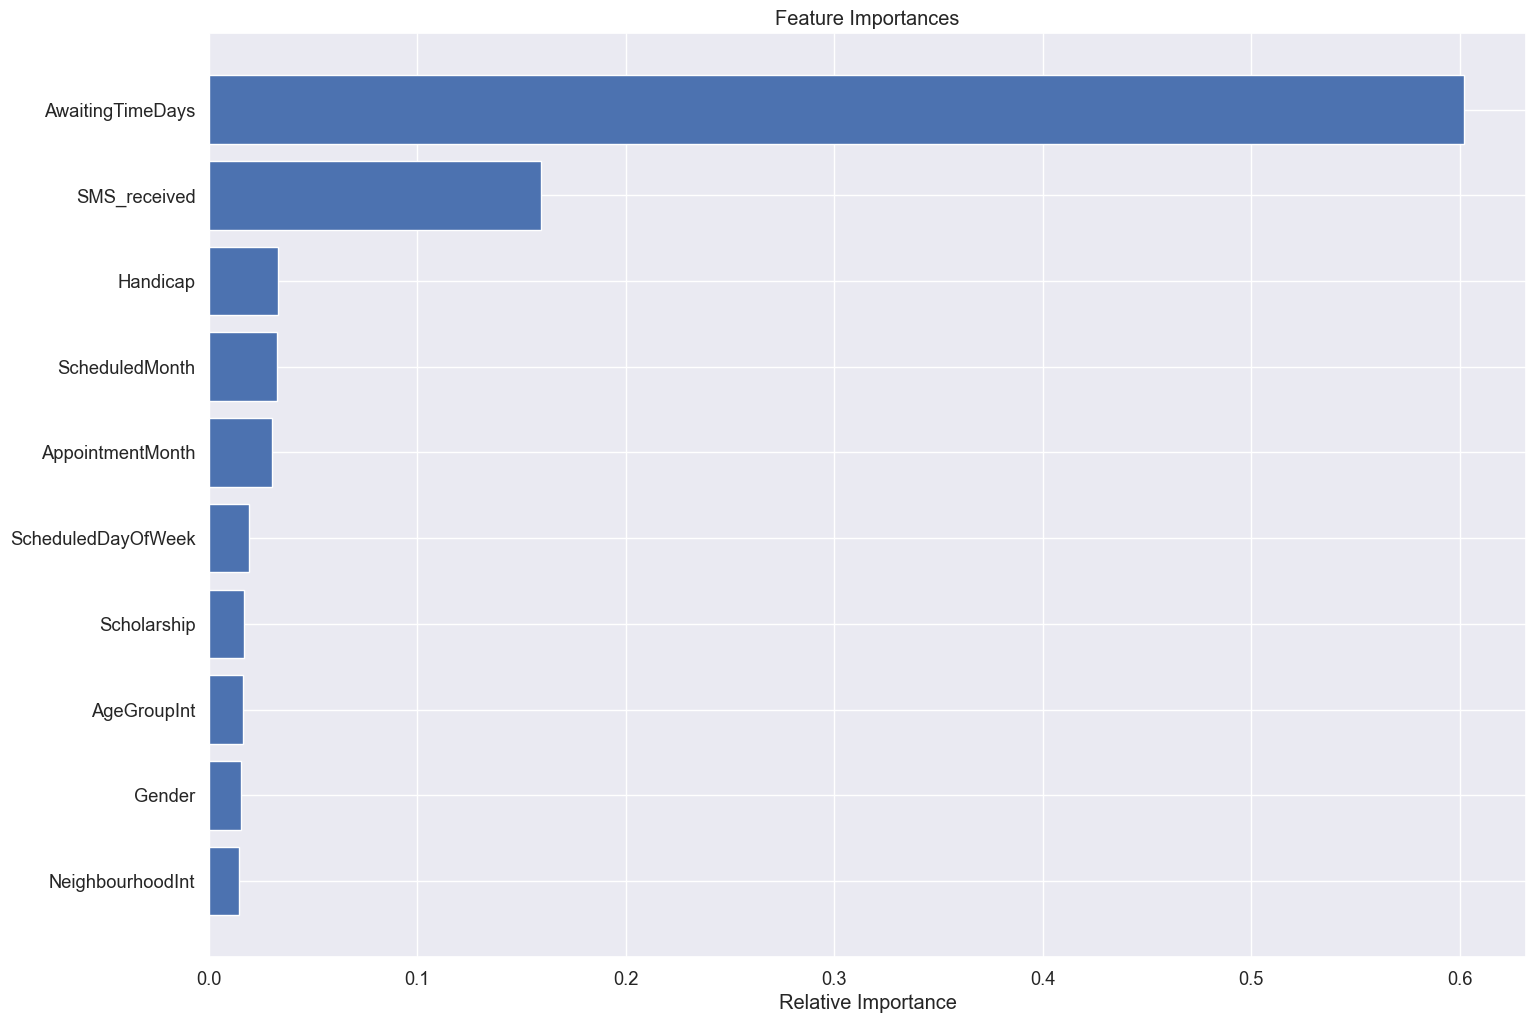

In [13]:
importances_xgboost = xgboost_cls.feature_importances_
plt.figure(figsize=(17, 12))
sns.set(font_scale=1.2)
indices = np.argsort(importances_xgboost)[-10:]
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances_xgboost[indices], color='b', align='center')
plt.yticks(range(len(indices)), X.columns[indices])
plt.xlabel('Relative Importance')
plt.show()

### Random Forest

#### Hyperparameter tuning

In [27]:
config = {
    "name": "Random Forest",
    "method": "bayes",
    "metric": {
        "name": "accuracy",
        "goal": "maximize",
    },
    "parameters": {
        "n_estimators": {
            "values": [10, 50, 100, 150, 200]
        },
        "criterion": {
            "values": ["gini", "entropy", "log_loss"],
        },
        "min_samples_split": {
            "values": [2, 4, 6]
        },
        "min_samples_leaf": {
            "values": [1, 2, 3]
        },
    }
}

In [28]:
def train():
    wandb.init(project=WANDB_PROJECT_NAME, config=wandb.config)

    config = wandb.config

    model = RandomForestClassifier(
        n_estimators=config.n_estimators,
        criterion=config.criterion,
        max_depth=None,
        min_samples_split=config.min_samples_split,
        min_samples_leaf=config.min_samples_leaf,
        max_features='auto',
        verbose=0,
        random_state=42,
    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    precision = precision_score(y_test, y_pred, average='macro')

    wandb.log({"accuracy": accuracy, "f1": f1})
    wandb.log({"recall": recall, "precision": precision})

In [29]:
sweep_id = wandb.sweep(config, project=WANDB_PROJECT_NAME)
wandb.agent(sweep_id, function=train, count=15)

Create sweep with ID: sn46ukqd
Sweep URL: https://wandb.ai/polejowska/mappshow-hp-optimize/sweeps/sn46ukqd


wandb: Agent Starting Run: w3dbneqb with config:
wandb: 	criterion: gini
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.95623
f1,0.95612
precision,0.95702
recall,0.95565


wandb: Agent Starting Run: a89r8nq8 with config:
wandb: 	criterion: entropy
wandb: 	min_samples_leaf: 2
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 150
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.9543
f1,0.95418
precision,0.95517
recall,0.95368


wandb: Agent Starting Run: jjdx2pr0 with config:
wandb: 	criterion: entropy
wandb: 	min_samples_leaf: 3
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 50
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.9513
f1,0.95117
precision,0.95222
recall,0.95066


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 11e8boqj with config:
wandb: 	criterion: gini
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.95623
f1,0.95612
precision,0.95702
recall,0.95565


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wce6hqro with config:
wandb: 	criterion: entropy
wandb: 	min_samples_leaf: 2
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 50
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.95444
f1,0.95433
precision,0.95532
recall,0.95383


wandb: Agent Starting Run: itj4nvya with config:
wandb: 	criterion: gini
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.95623
f1,0.95612
precision,0.95702
recall,0.95565


wandb: Agent Starting Run: lxbn6j9z with config:
wandb: 	criterion: gini
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.95623
f1,0.95612
precision,0.95702
recall,0.95565


wandb: Agent Starting Run: kxx3qu9o with config:
wandb: 	criterion: gini
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.95623
f1,0.95612
precision,0.95702
recall,0.95565


wandb: Agent Starting Run: mfg1n9z8 with config:
wandb: 	criterion: gini
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.95623
f1,0.95612
precision,0.95702
recall,0.95565


wandb: Agent Starting Run: ut40fzyd with config:
wandb: 	criterion: gini
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.95623
f1,0.95612
precision,0.95702
recall,0.95565


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pfcx2u4n with config:
wandb: 	criterion: gini
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.95623
f1,0.95612
precision,0.95702
recall,0.95565


wandb: Agent Starting Run: gjs5pspm with config:
wandb: 	criterion: gini
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.95623
f1,0.95612
precision,0.95702
recall,0.95565


wandb: Agent Starting Run: bagvycyz with config:
wandb: 	criterion: gini
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.95623
f1,0.95612
precision,0.95702
recall,0.95565


wandb: Agent Starting Run: hbvah6b1 with config:
wandb: 	criterion: gini
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.95623
f1,0.95612
precision,0.95702
recall,0.95565


wandb: Agent Starting Run: jef0tur6 with config:
wandb: 	criterion: gini
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.95623
f1,0.95612
precision,0.95702
recall,0.95565


In [30]:
wandb.finish()

#### Random Forest with the best hyperparameters training and evaluation

In [20]:
best_config = {
    "criterion": "gini",
    "min_samples_leaf": 1,
    "min_samples_split": 3,
    "n_estimators": 200,
}

rf_cls = RandomForestClassifier(
    n_estimators=best_config['n_estimators'],
    criterion=best_config['criterion'],
    max_depth=None,
    min_samples_split=best_config['min_samples_split'],
    min_samples_leaf=best_config['min_samples_leaf'],
    max_features='auto',
    verbose=0,
    random_state=42,
)

rf_cls.fit(X_train, y_train)

y_pred = rf_cls.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

print('Accuracy: %.2f%%' % (accuracy * 100.0))
print('F1 score: %.2f%%' % (f1 * 100.0))

Accuracy: 95.75%
F1 score: 95.74%


#### Feature importance

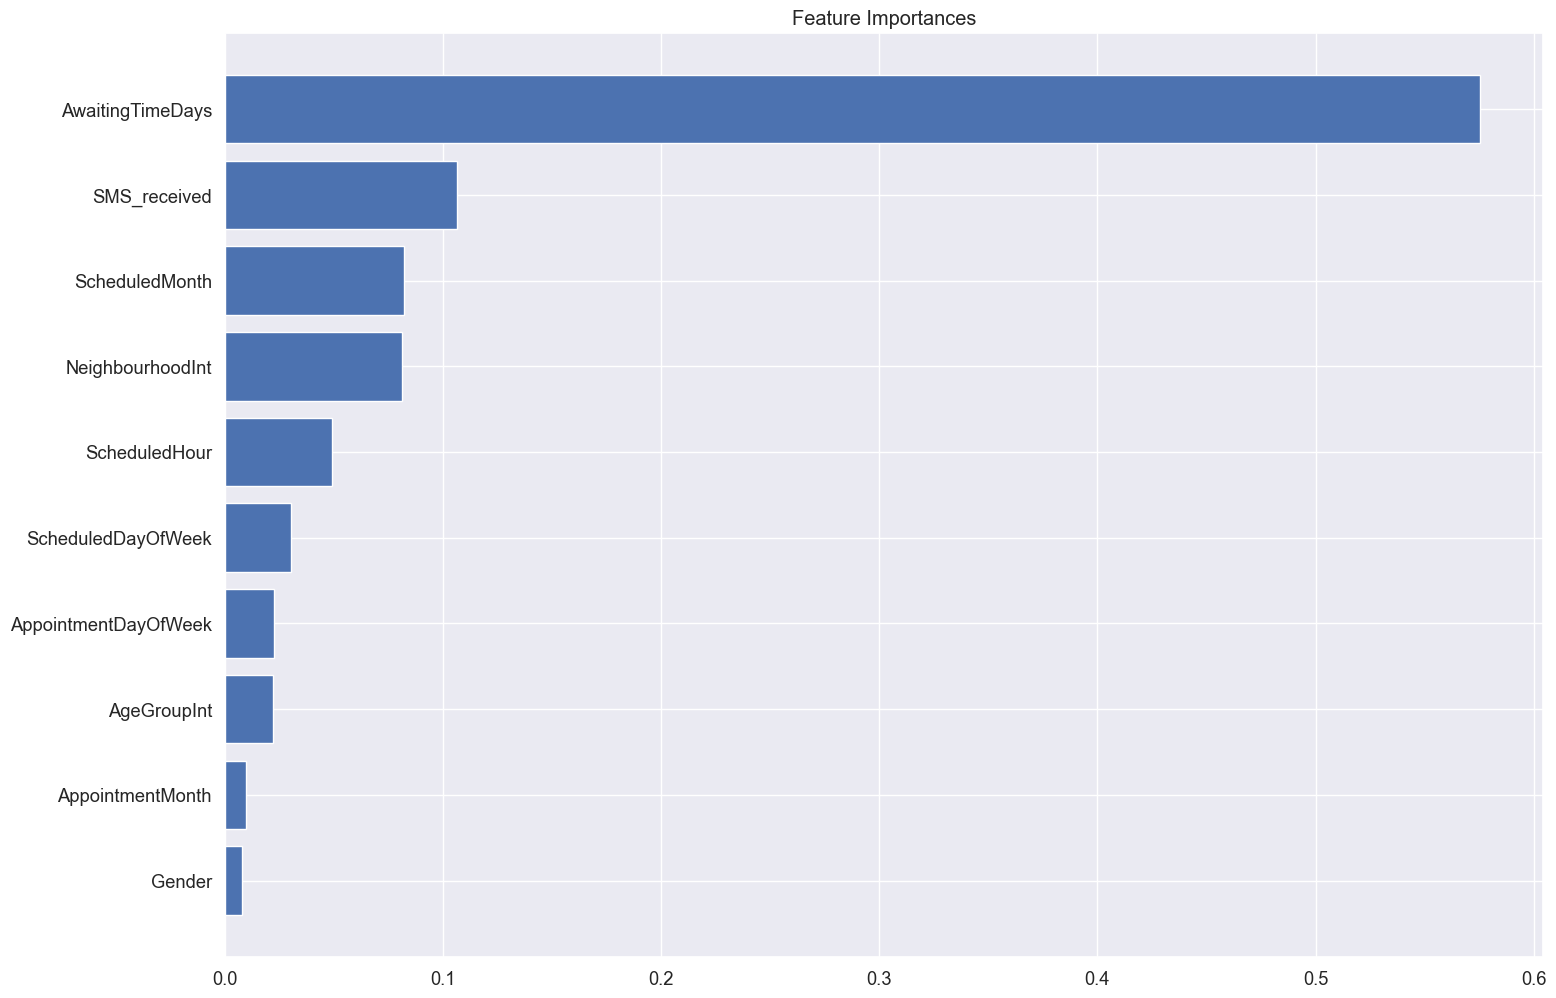

In [21]:
importances_rf = rf_cls.feature_importances_
# plot the feature importances and the feature names
plt.figure(figsize=(17, 12))
sns.set(font_scale=1.2)
# limit to ten features
indices = np.argsort(importances_rf)[-10:]
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances_rf[indices], color='b', align='center')
plt.yticks(range(len(indices)), X.columns[indices])
plt.show()

#### LIME 

In [26]:
X_test.shape

(14005, 15)

In [27]:
lime = LimeTabular(
    model=rf_cls,
    data=X_train,
    random_state=1
)

lime_local = lime.explain_local(
    X_test[14002:],
    y_test[14002:],
    name='LIME'
)

show(lime_local)

<!-- http://127.0.0.1:7001/11264061744/ -->

#### SHAP

### Gradient Boosting

In [27]:
gb_cls = GradientBoostingClassifier(
    max_depth=7,
    n_estimators=120,
    learning_rate=0.1,
    random_state=42
)

gb_cls.fit(X_train, y_train)

y_pred = gb_cls.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

print('Accuracy: %.2f%%' % (accuracy * 100.0))
print('F1 score: %.2f%%' % (f1 * 100.0))

Accuracy: 95.31%
F1 score: 95.30%


#### Feature importance

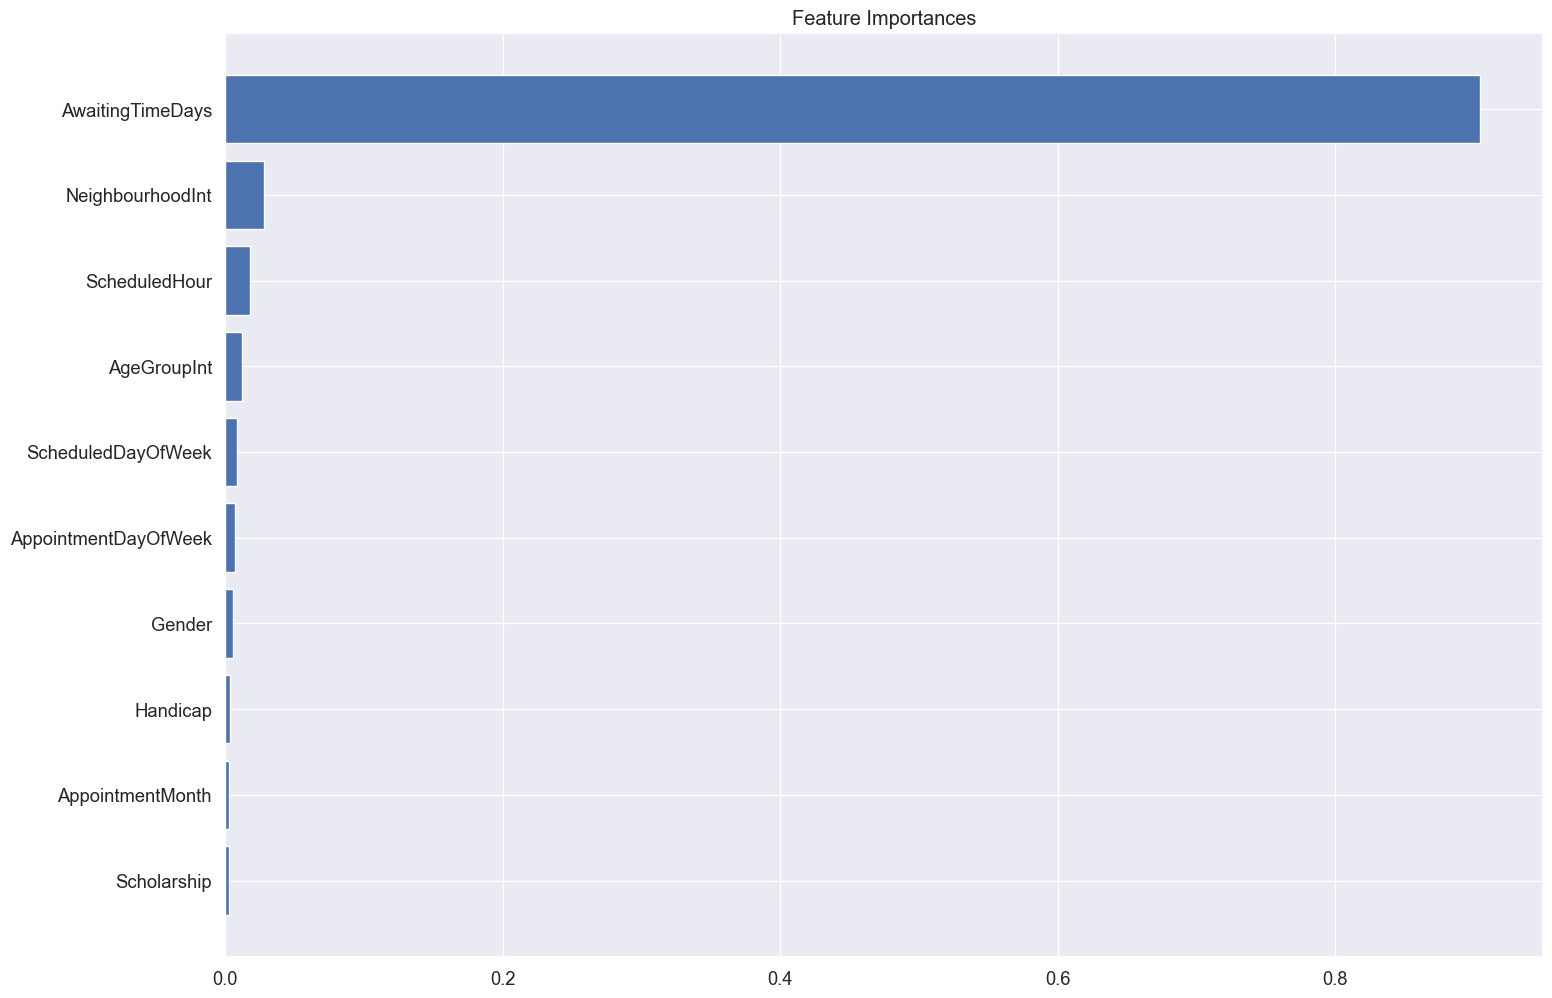

In [28]:
importances_gb = gb_cls.feature_importances_
plt.figure(figsize=(17, 12))
sns.set(font_scale=1.2)
indices = np.argsort(importances_gb)[-10:]
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances_gb[indices], color='b', align='center')
plt.yticks(range(len(indices)), X.columns[indices])
plt.show()

#### Partial Dependence Plots (PDPs)

Show the relationship between the target variable and features.


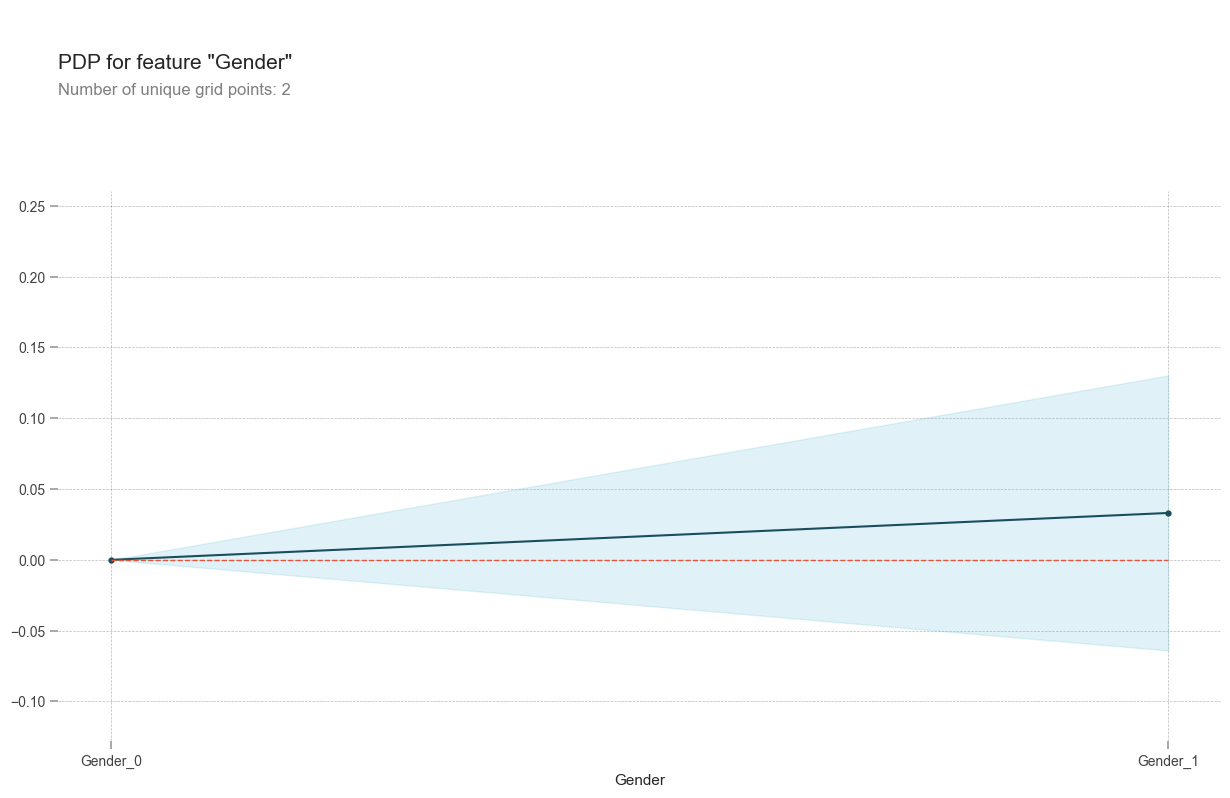

In [48]:
pdp_dist = pdp.pdp_isolate(model=gb_cls, dataset=X, model_features=X.columns, feature='Gender')
pdp.pdp_plot(pdp_dist, 'Gender')
plt.show()


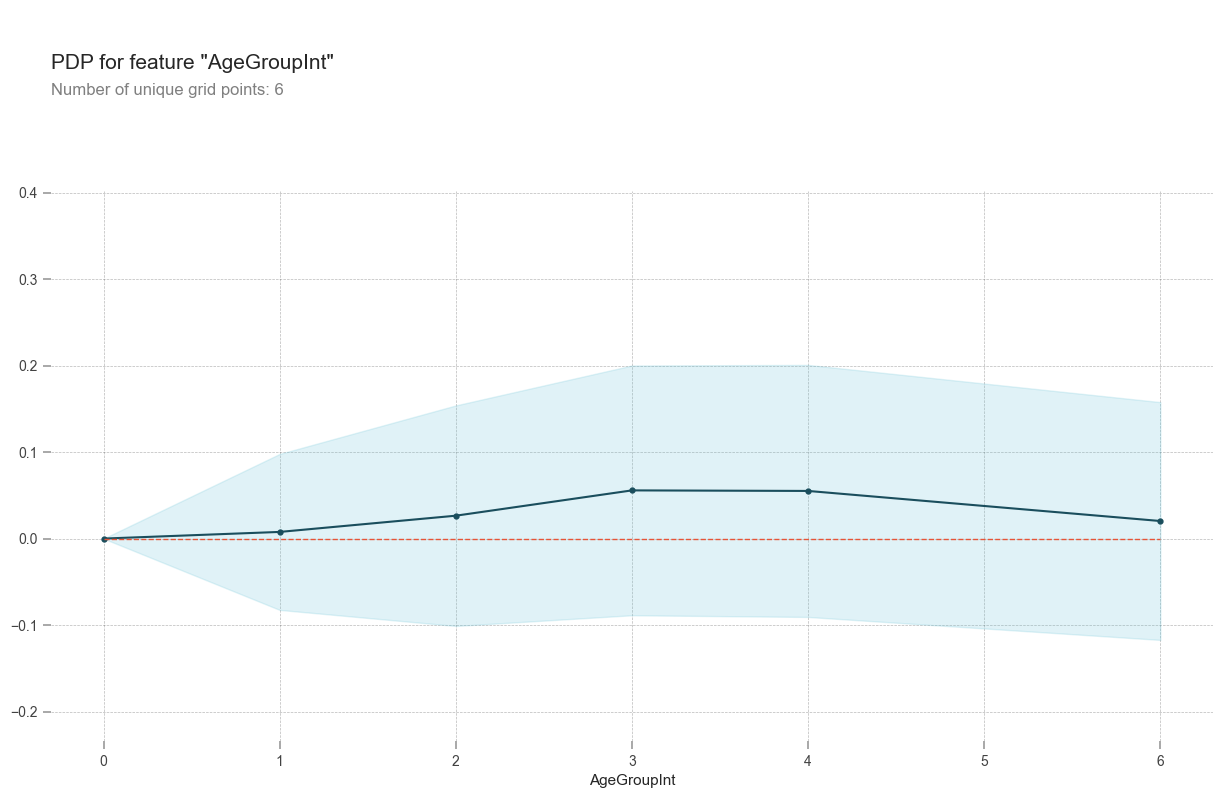

In [51]:
pdp_dist = pdp.pdp_isolate(model=gb_cls, dataset=X, model_features=X.columns, feature='AgeGroupInt')
pdp.pdp_plot(pdp_dist, 'AgeGroupInt')
plt.show()

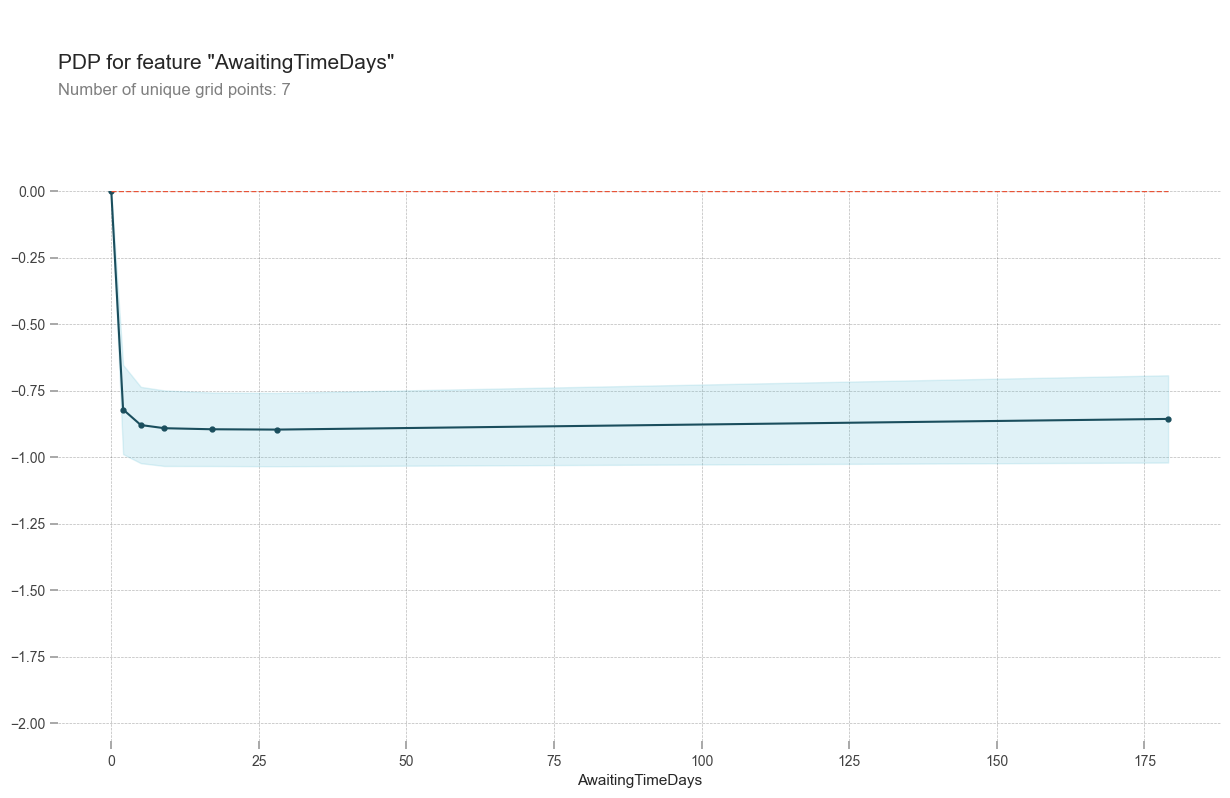

In [52]:
pdp_dist = pdp.pdp_isolate(model=gb_cls, dataset=X, model_features=X.columns, feature='AwaitingTimeDays')
pdp.pdp_plot(pdp_dist, 'AwaitingTimeDays')
plt.show()

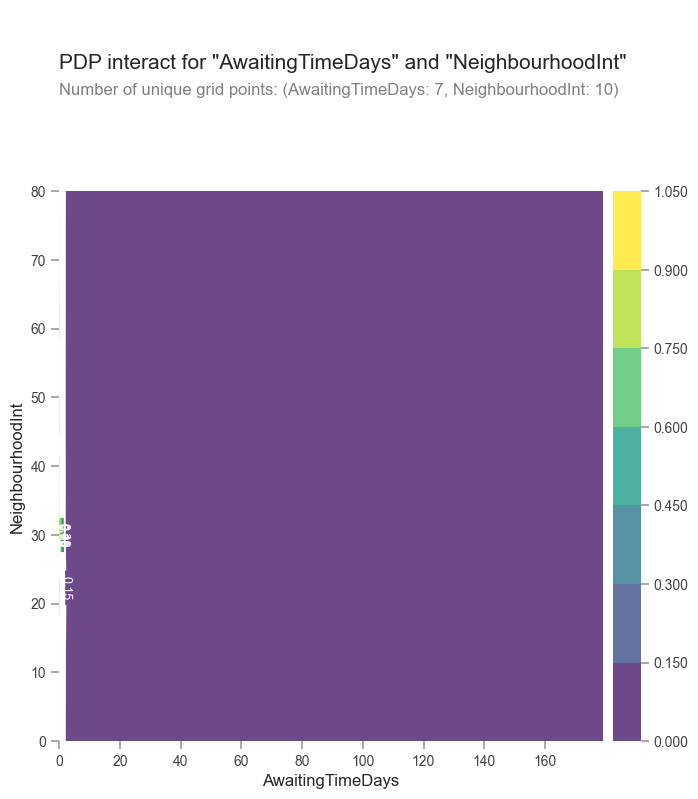

In [53]:
# pdp for feature combination (2 features, 'AwaitingTimeDays' and 'NeighbourhoodInt')
pdp_dist = pdp.pdp_interact(model=gb_cls, dataset=X, model_features=X.columns, features=['AwaitingTimeDays', 'NeighbourhoodInt'])
pdp.pdp_interact_plot(pdp_dist, ['AwaitingTimeDays', 'NeighbourhoodInt'], plot_type='contour')
plt.show()

### AdaBoost

In [16]:
ada = AdaBoostClassifier(n_estimators=100, random_state=101)

ada.fit(X_train, y_train)

y_pred = ada.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

print('Accuracy: %.2f%%' % (accuracy * 100.0))
print('F1 score: %.2f%%' % (f1 * 100.0))

Accuracy: 94.31%
F1 score: 94.29%


#### Feature importance

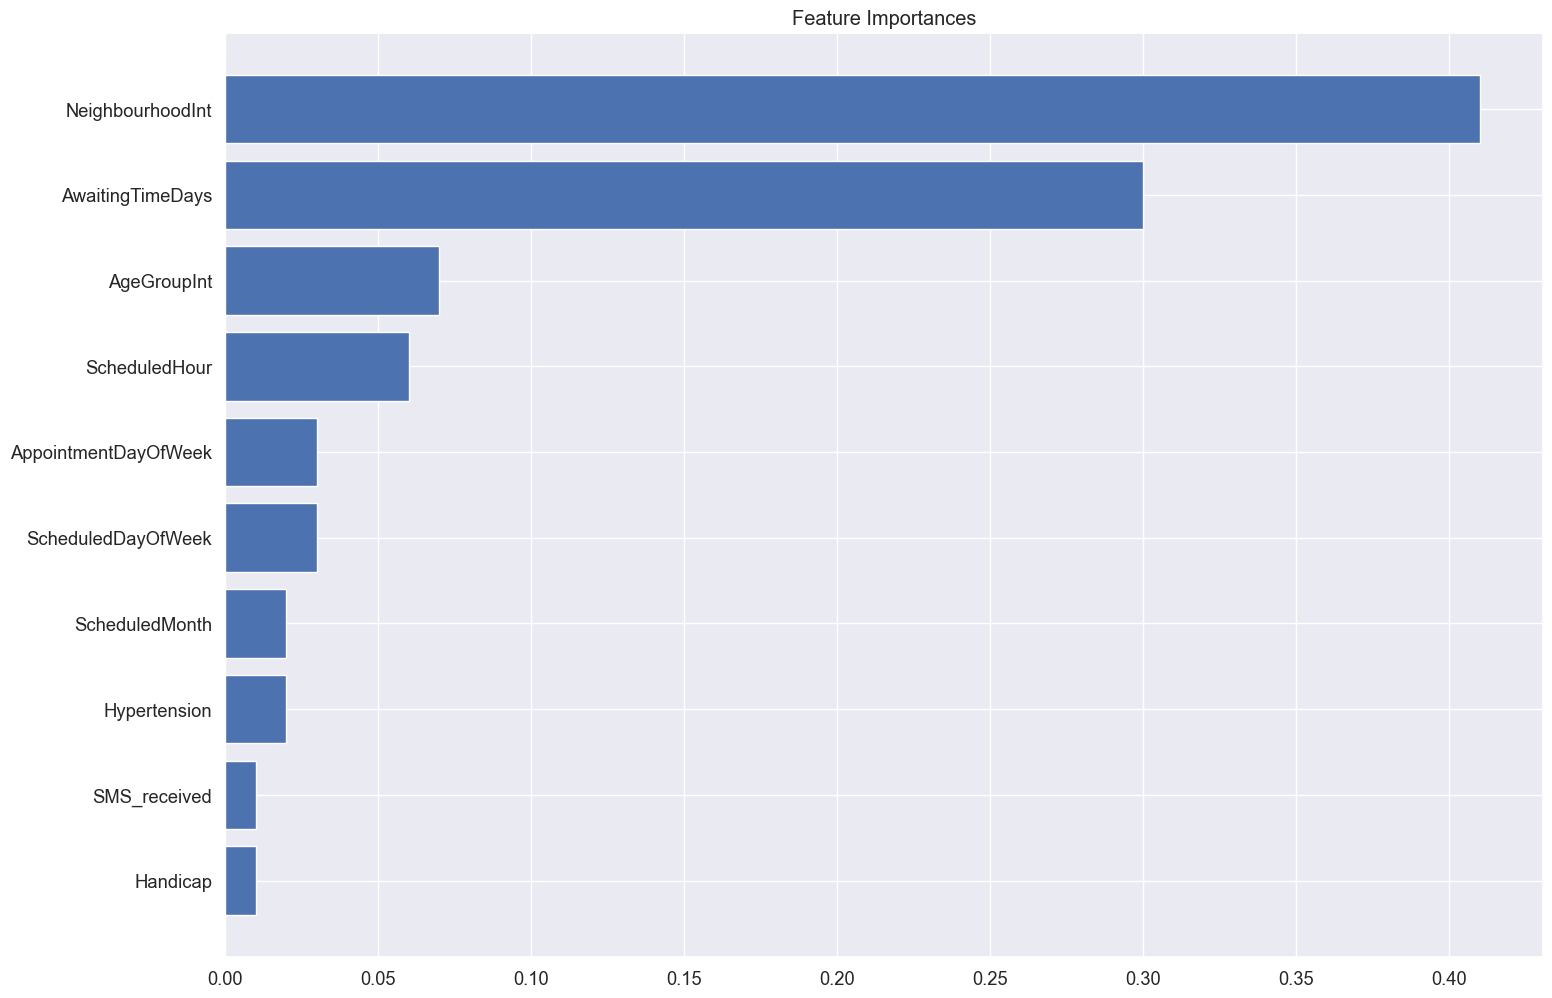

In [29]:
importances_ada = ada.feature_importances_
plt.figure(figsize=(17, 12))
sns.set(font_scale=1.2)
indices = np.argsort(importances_ada)[-10:]
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances_ada[indices], color='b', align='center')
plt.yticks(range(len(indices)), X.columns[indices])
plt.show()